In [2]:
import os
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import  to_categorical
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, MobileNet
from tensorflow.keras.layers import Dense, Rescaling, Resizing, Input, Flatten, Dropout, Conv2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import models

In [3]:
def test(model, test_x, test_y, size):
  fig, ax = plt.subplots(1, size, figsize=(20, 5))

  for i in range(size):
    idx = random.randint(0, len(test_x)-1)
    ax[i].imshow(test_x[idx])
    pred = model.predict(np.expand_dims(test_x[idx], axis = 0))
    pred = np.argmax(pred, axis = 1)
    y_pred = label_encode.inverse_transform(pred)
    y_true = label_encode.inverse_transform([np.argmax(test_y[idx])])
    ax[i].set_title(f'Label: {y_true[0]}, Predict: {y_pred[0]}')
    ax[i].axis('off')
  plt.show()

def plot(h):
  _, ax = plt.subplots(1, 2, figsize=(20, 5))

  ax[0].plot(h.history['acc'])
  ax[0].plot(h.history['val_acc'])
  ax[0].set_title('model accuracy')
  ax[0].set_ylabel('accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].legend(['train', 'val'])

  ax[1].plot(h.history['loss'])
  ax[1].plot(h.history['val_loss'])
  ax[1].set_title('model loss')
  ax[1].set_ylabel('loss')
  ax[1].set_xlabel('epoch')
  ax[1].legend(['train', 'val'])

In [4]:
%cp -rf '/content/drive/MyDrive/data/train/archive (4).zip' '/content/'

In [5]:
!unzip '/content/archive (4).zip'
from IPython.display import clear_output
clear_output()

In [ ]:
#%cp -rf '/content/drive/MyDrive/data/train/asl_alphabet_train.zip' '/content/'

^C


In [ ]:
#!unzip '/content/asl_alphabet_train.zip'
#from IPython.display import clear_output
#clear_output()

In [ ]:
#!unzip '/content/asl_alphabet_train.zip' 
#-d "/content/drive/MyDrive/data/train/asl-alphabet-train"

In [6]:
path = '/content/asl_alphabet_train/asl_alphabet_train/'
label_encode = LabelEncoder().fit(os.listdir(path))

In [7]:
os.listdir(path)

['V',
 'E',
 'R',
 'U',
 'F',
 'nothing',
 'B',
 'C',
 'del',
 'M',
 'S',
 'Y',
 'G',
 'L',
 'Z',
 'P',
 'A',
 'X',
 'Q',
 'space',
 'K',
 'T',
 'D',
 'J',
 'H',
 'O',
 'N',
 'I',
 'W']

In [8]:
train_x = []
train_y = []
for i in os.listdir(path):
  x = 0
  for j in os.listdir(path+i):
    if x == 1500:
      break
    img = plt.imread(f'{path}{i}/{j}')
    train_x.append(img)
    train_y.append(i)
    x += 1

In [9]:
train_x = np.array(train_x)
train_y = label_encode.fit_transform(train_y)
train_x.shape, train_y.shape

((43500, 200, 200, 3), (43500,))

In [10]:
order = [i for i in range(len(train_x))]
random.shuffle(order)
train_x = train_x[order]
train_y = train_y[order]

In [11]:
train_y = to_categorical(train_y, num_classes=len(label_encode.classes_))  

In [12]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size = 0.2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2)

In [ ]:
VGG16().summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [13]:
inp = Input(shape=(200, 200, 3))
resize = Resizing(224, 224)(inp)
rescal = Rescaling(1/255)(resize)
vgg16 = VGG16(input_tensor=rescal, weights="imagenet")
vgg16.trainable = False
x = Flatten()(vgg16.layers[-5].output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(len(label_encode.classes_), activation='softmax')(x)

model_VGG16 = Model(inputs = inp, outputs = x)
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856 

In [14]:
model_VGG16.compile(optimizer=Adam(), loss = categorical_crossentropy, metrics=['acc'])
VGG_16 = model_VGG16.fit(train_x, train_y, batch_size=64, epochs=10, validation_data=(val_x, val_y))
model_VGG16.save('/content/drive/MyDrive/data/CNN-Model/asl.h5')

Epoch 1/10
435/435 [==============================] - 182s 388ms/step - loss: 1.8196 - acc: 0.4446 - val_loss: 0.5124 - val_acc: 0.8829
Epoch 2/10
435/435 [==============================] - 173s 399ms/step - loss: 0.7757 - acc: 0.7398 - val_loss: 0.2393 - val_acc: 0.9323
Epoch 3/10
435/435 [==============================] - 176s 406ms/step - loss: 0.5682 - acc: 0.8102 - val_loss: 0.1952 - val_acc: 0.9547
Epoch 4/10
435/435 [==============================] - 177s 406ms/step - loss: 0.4528 - acc: 0.8455 - val_loss: 0.1226 - val_acc: 0.9710
Epoch 5/10
435/435 [==============================] - 177s 406ms/step - loss: 0.3957 - acc: 0.8665 - val_loss: 0.0756 - val_acc: 0.9826
Epoch 6/10
435/435 [==============================] - 176s 404ms/step - loss: 0.3506 - acc: 0.8829 - val_loss: 0.0849 - val_acc: 0.9790
Epoch 7/10
435/435 [==============================] - 176s 404ms/step - loss: 0.3103 - acc: 0.8936 - val_loss: 0.0588 - val_acc: 0.9899
Epoch 8/10
435/435 [============================

In [15]:
model = models.load_model('/content/drive/MyDrive/data/CNN-Model/asl.h5')

In [16]:
!cp -rf '/content/asl_alphabet_test' '/content/drive/MyDrive/data/CNN-Model'

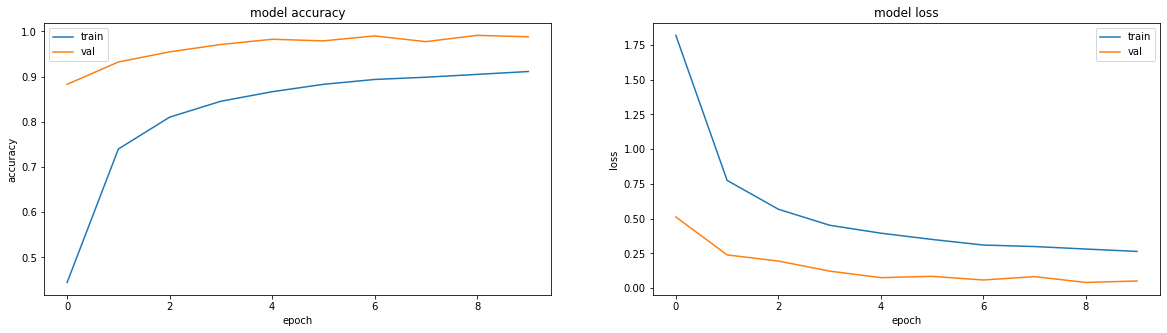

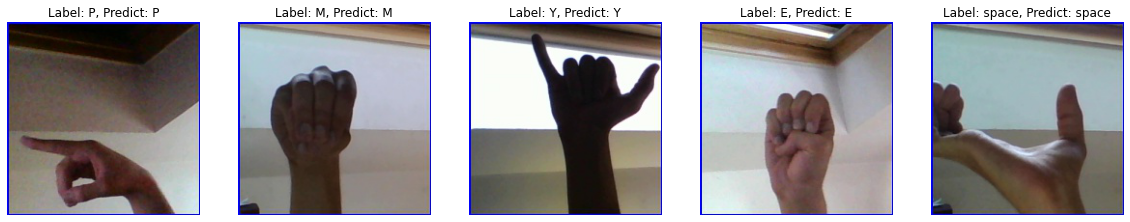

In [17]:
plot(VGG_16)
test(model_VGG16, test_x, test_y, 5)

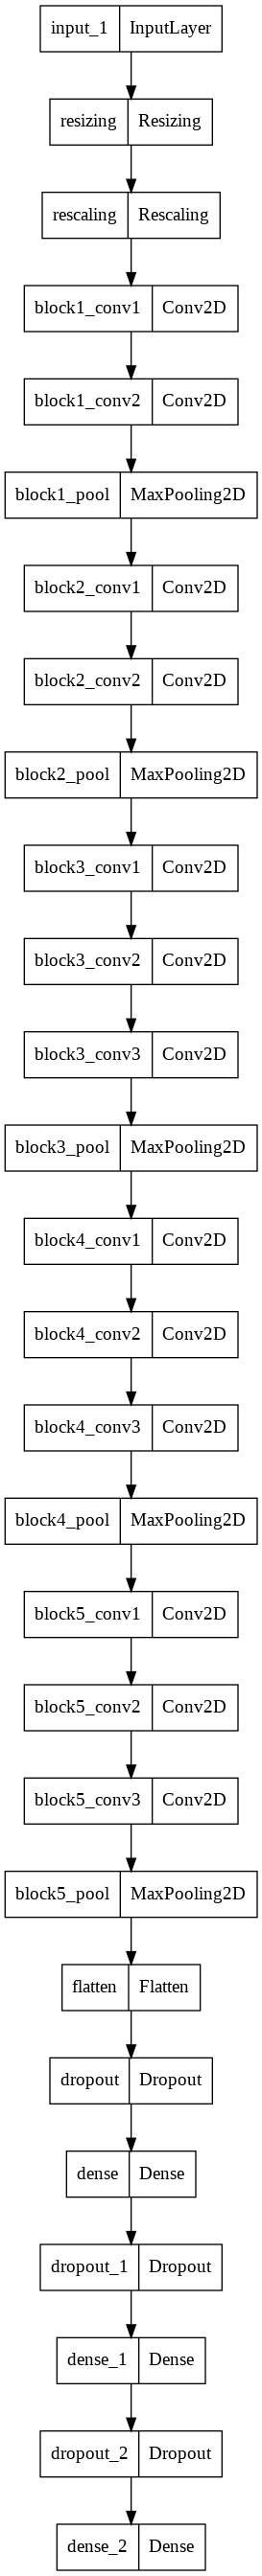

In [24]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

In [ ]:
VGG19().summary()

574726144/574710816 [==============================] - 5s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [25]:
inp = Input(shape=(200, 200, 3))
resize = Resizing(224, 224)(inp)
rescal = Rescaling(1/255)(resize)
vgg19 = VGG19(input_tensor=rescal, weights="imagenet")
vgg19.trainable = False
x = Flatten()(vgg19.layers[-5].output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(len(label_encode.classes_), activation='softmax')(x)

model_VGG19 = Model(inputs = inp, outputs = x)
model_VGG19.summary()

574726144/574710816 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                          

In [ ]:
model_VGG19.compile(optimizer=Adam(), loss = categorical_crossentropy, metrics=['acc'])
VGG19 = model_VGG19.fit(train_x, train_y, batch_size=64, epochs=10, validation_data=(val_x, val_y))

Epoch 1/10
435/435 [==============================] - 348s 797ms/step - loss: 2.3932 - acc: 0.2777 - val_loss: 1.1689 - val_acc: 0.7138
Epoch 2/10
435/435 [==============================] - 346s 795ms/step - loss: 1.5107 - acc: 0.5073 - val_loss: 0.7238 - val_acc: 0.8375
Epoch 3/10
435/435 [==============================] - 346s 795ms/step - loss: 1.2641 - acc: 0.5843 - val_loss: 0.6060 - val_acc: 0.8707
Epoch 4/10
435/435 [==============================] - 346s 796ms/step - loss: 1.1227 - acc: 0.6295 - val_loss: 0.5940 - val_acc: 0.8634
Epoch 5/10
435/435 [==============================] - 345s 793ms/step - loss: 1.0463 - acc: 0.6549 - val_loss: 0.3797 - val_acc: 0.9187
Epoch 6/10
435/435 [==============================] - 342s 786ms/step - loss: 1.0160 - acc: 0.6640 - val_loss: 0.4101 - val_acc: 0.9256
Epoch 7/10
435/435 [==============================] - 342s 787ms/step - loss: 0.9444 - acc: 0.6887 - val_loss: 0.3592 - val_acc: 0.9374
Epoch 8/10
435/435 [============================

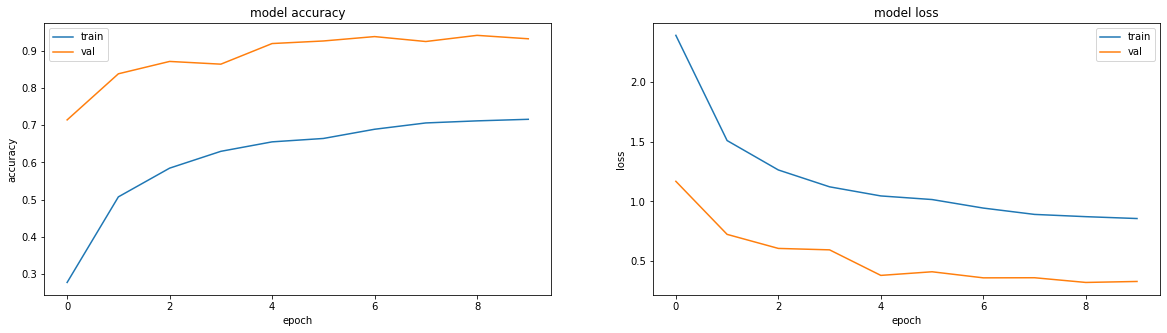

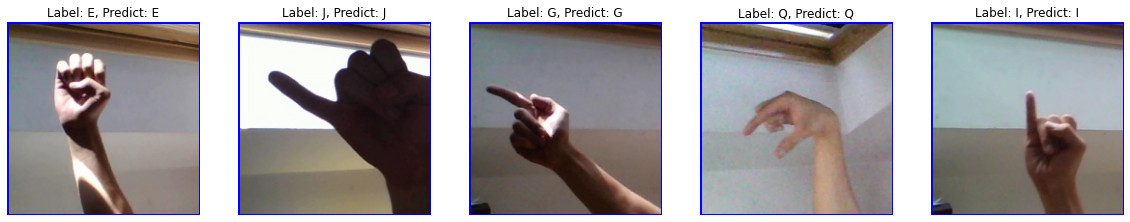

In [ ]:
plot(VGG19)
test(model_VGG19, test_x, test_y, 5)

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model)